<a href="https://colab.research.google.com/github/pablo-arantes/making-it-rain/blob/main/BioEmu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Biomolecular Emulator (BioEmu for short), a model that samples from the approximated equilibrium distribution of structures for a protein monomer, given its amino acid sequence.
BioEmu outputs structures in backbone frame representation. To reconstruct the side-chains, several tools are available. As an example, we interface with HPacker (https://github.com/gvisani/hpacker) to conduct side-chain reconstruction.

BioEmu is based on the paper:

📄 Scalable emulation of protein equilibrium ensembles with generative deep learning

👨‍🔬 Authors: Sarah Lewis & Frank Noé (corresponding), et al.

📌 Read it here: https://www.biorxiv.org/content/10.1101/2024.12.05.626885v1.abstract

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to emulate of protein equilibrium ensembles with generative deep learning model in a cheap and yet feasible fashion.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the [BioEmu](https://github.com/microsoft/bioemu) team for developing an excellent and open source model.

- A Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# Introduction

In terms of inputs, we wil need:
*  An amino acid sequence of your protein.

In this notebook, we will emulate an equilibrium ensembles of a chignolin protein.







## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive.
2.   Copy the path of your created directory. We will use it below.

---
---
## Setting the environment for our calculations

Firstly, we need to install all necessary libraries and packages. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    BioEmu (https://github.com/microsoft/bioemu)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import sys
import os
import subprocess

commands = [
    # "pip install bioemu",
    "pip install git+https://github.com/pablo-arantes/bioemu",
    "pip -q install py3Dmol",
    "pip install --upgrade MDAnalysis==2.4.2",
    "mamba install -c conda-forge ambertools -y",

]

for cmd in commands:
    subprocess.run(cmd, shell=True)

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Mar  1 00:39:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [42]:
#@title **Please, provide the necessary inputs**:

Google_Drive_Path = '/content/drive/MyDrive/BioEmu' #@param {type:"string"}
workDir = Google_Drive_Path
Sequence = 'GYDPETGTWG' #@param {type:"string"}
number_of_samples = 1000 #@param {type:"slider", min:10, max:5000, step:10}
output = 'test_chignolin' #@param {type:"string"}
import os
from bioemu.sample import main as sample
sample(sequence=Sequence, num_samples=int(number_of_samples), output_dir=os.path.join(workDir, output))

In [43]:
#@title **Concatenate and align the ensemble trajectory**
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import pytraj as pt

workDir = Google_Drive_Path
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]


workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology.pdb")
traj = os.path.join(workDir2, "samples.xtc")

# traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
nw_dcd = os.path.join(workDir2, "samples_fix." + str(Output_format))
nw_pdb = os.path.join(workDir2, "topology_fix.pdb")



u1 = mda.Universe(pdb_ref, traj)
u2 = mda.Universe(pdb_ref, pdb_ref)

u2.trajectory[0] # set u2 to first frame

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

nw = u1.select_atoms("all")
with mda.Writer(nw_dcd, nw.n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(nw, )
not_waters = u2.select_atoms("all")
not_waters.write(nw_pdb)
traj_dcd_check = os.path.exists(nw_dcd)
traj = nw_dcd
pdb_ref = nw_pdb


traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 1000 frames: 
Size: 0.001051 (GB)
<Topology: 47 atoms, 10 residues, 2 mols, PBC with box type = cubic>
           
Trajectory concatenated successfully! :-)


In [44]:
#@title **Load, view and check the ensemble**
#@markdown This will take a few minutes.
import warnings
warnings.filterwarnings('ignore')
import py3Dmol
import MDAnalysis as mda
#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr


stride_animation =  100 #@param {type:"slider", min:0, max:1000, step:10}

workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
traj = os.path.join(workDir2, "samples_fix.dcd")

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('all')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Principal component analysis (PCA)**

Principal component analysis is a common linear dimensionality reduction technique that maps the coordinates in each frame of your trajectory to a linear combination of orthogonal vectors. The vectors are called principal components, and they are ordered such that the first principal component accounts for the most variance in the original data (i.e. the largest uncorrelated motion in your trajectory), and each successive component accounts for less and less variance. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA. Please see http://www.springer.com/gp/book/9780387954424 and https://doi.org/10.1063/1.4885338, for a more in-depth introduction to PCA.

In [45]:
#@title **Calculating the Principal component analysis (PCA)**
import warnings
warnings.filterwarnings('ignore')

#@markdown **Provide inputs below:**
Selection1 = '1' #@param {type:"string"}
Selection2 = '10' #@param {type:"string"}

import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca

u = mda.Universe(pdb_ref,traj)
pca_calc = pca.PCA(u, select=f'resid {Selection1}:{Selection2}')
pca_calc.run()

Cumulated variance for PC1: 0.419
Cumulated variance for PC2: 0.551
Cumulated variance for PC3: 0.635
Cumulated variance for PC4: 0.693
Cumulated variance for PC5: 0.726
Cumulated variance for PC6: 0.758
Cumulated variance for PC7: 0.780
Cumulated variance for PC8: 0.800
Cumulated variance for PC9: 0.818
Cumulated variance for PC10: 0.836


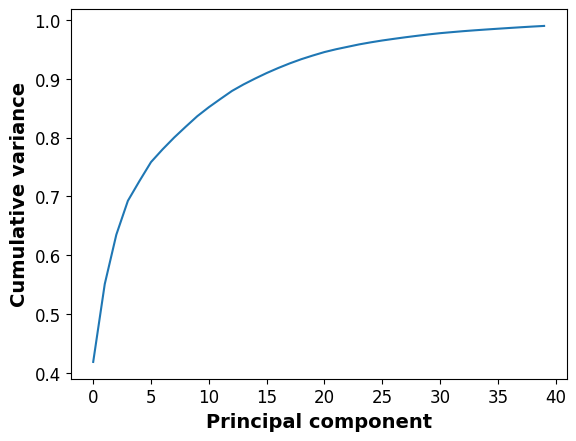

In [46]:
#@title **Calculating the Variance of Each Principal Component**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n_pcs = np.where(pca_calc.cumulated_variance > 0.99)[0][0]
atomgroup = u.select_atoms(f'resid {Selection1}:{Selection2}')
pca_space = pca_calc.transform(atomgroup, n_components=n_pcs)

for i in range(10):
    print(f"Cumulated variance for PC{i+1}: {pca_calc.cumulated_variance[i]:.3f}")

transformed = pca_calc.transform(atomgroup, n_components=n_pcs)
transformed.shape
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(n_pcs)])
df['Frame'] = df.index * u.trajectory.dt

plt.plot(pca_calc.cumulated_variance[:n_pcs])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Principal component', fontsize = 14, fontweight = 'bold')
plt.ylabel('Cumulative variance', fontsize = 14, fontweight = 'bold')
plt.show()

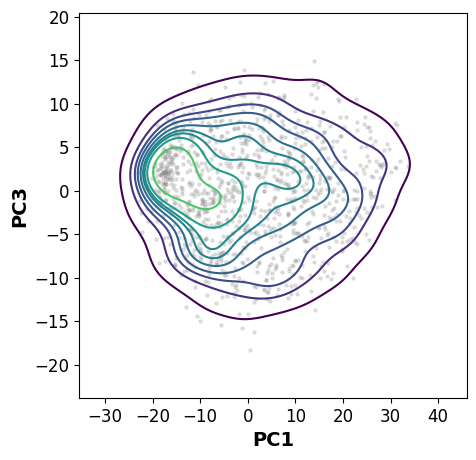

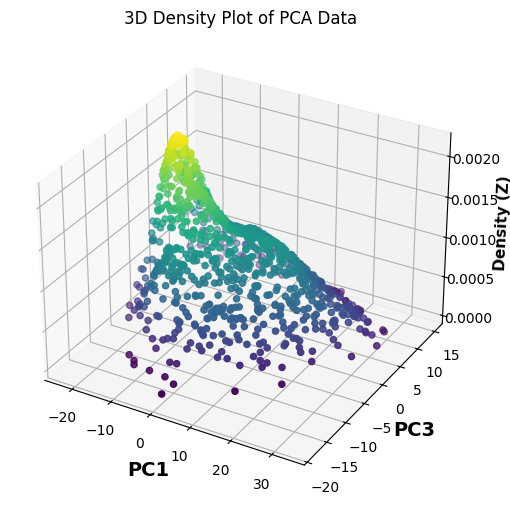

In [47]:
#@title **Plot the Principle Component Analysis (PCA)**

#@markdown **Provide which principal component you want to plot:**

PC_x = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
PC_y = "3" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

PC1 = df[f'PC{PC_x}'].tolist()
PC2 = df[f'PC{PC_y}'].tolist()

# Create the figure
plt.figure(figsize=(5, 5))
plt.scatter(PC1, PC2, s=5, color="gray", alpha=0.2)

# Plot a KDE contour map (no fill)
sns.kdeplot(x=PC1, y=PC2, cmap="viridis", levels=10, linewidths=1.5)

plt.xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
plt.ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_2D.png"), dpi=600, bbox_inches='tight')

# Compute KDE
xy = np.vstack([PC1, PC2])
kde = gaussian_kde(xy)(xy)  # Evaluates the density at each point

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Scatter plot with Z as density
ax.scatter(PC1, PC2, kde, c=kde, cmap='viridis')

# Labels
ax.set_xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
ax.set_ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
ax.set_zlabel("Density (Z)", fontsize = 11, fontweight = 'bold')
ax.set_title("3D Density Plot of PCA Data")

# plt.show()
plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_3D.png"), dpi=600, bbox_inches='tight')
pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, f"PC{PC_x}.csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, f"PC{PC_y}.csv"))

---
---
# **General Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of ensemble trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your ensemble behavior.

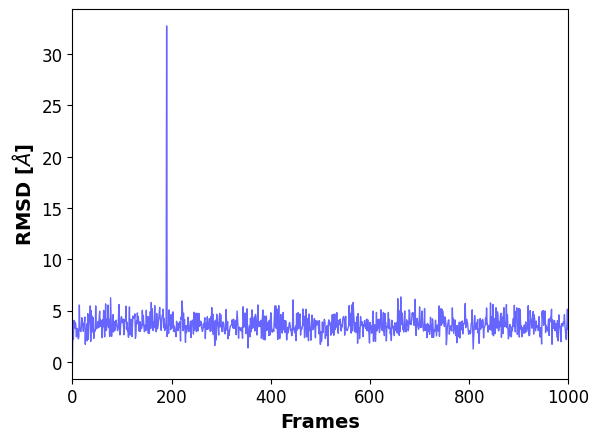

In [48]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:**
Output_name = 'rmsd_ca' #@param {type:"string"}

import matplotlib.pyplot as plt
import pandas as pd
rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

# Plotting:
ax = plt.plot(rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, len(rmsd))
#plt.ylim(2, 6)

plt.xlabel("Frames", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

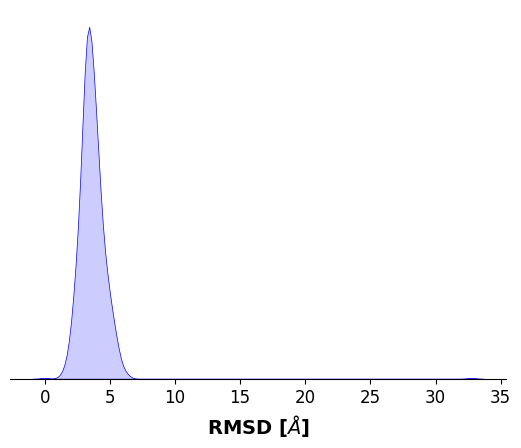

In [49]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}
import seaborn as sb
ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

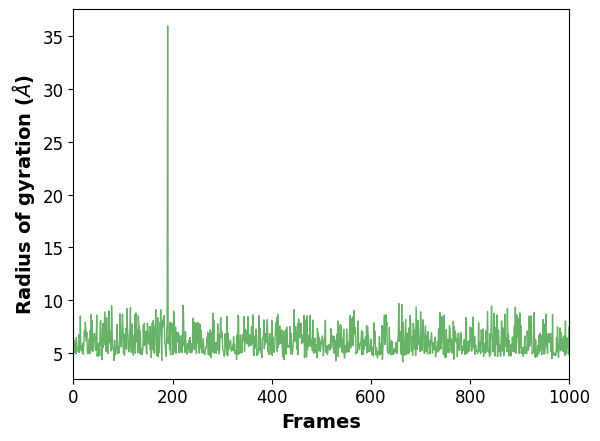

In [50]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
# Plotting:
plt.plot(radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, len(radgyr))
#plt.ylim(2, 6)

plt.xlabel("Frames", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

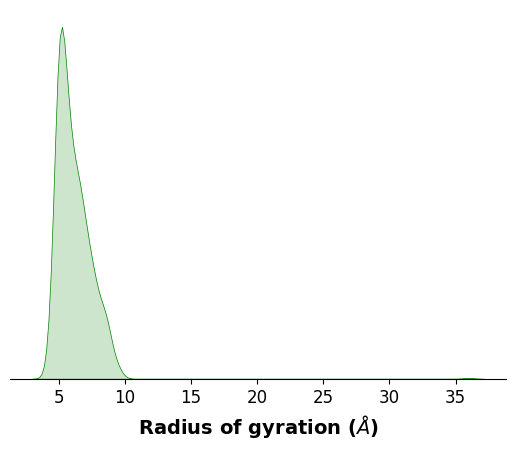

In [51]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

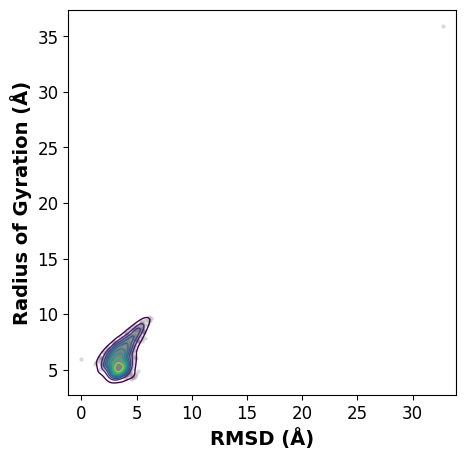

In [52]:
#@title **Plot RMSD X radius of gyration**

#@markdown **Provide output file names below:**

Output_name = 'rmsd_radius_gyration' #@param {type:"string"}
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Create the figure
plt.figure(figsize=(5, 5))
plt.scatter(rmsd, radgyr, s=5, color="gray", alpha=0.2)

# Plot a KDE contour map (no fill)
sns.kdeplot(x=rmsd, y=radgyr, cmap="viridis", levels=10, linewidths=1)

plt.xlabel(f"RMSD (Å)", fontsize = 14, fontweight = 'bold')
plt.ylabel(f"Radius of Gyration (Å)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

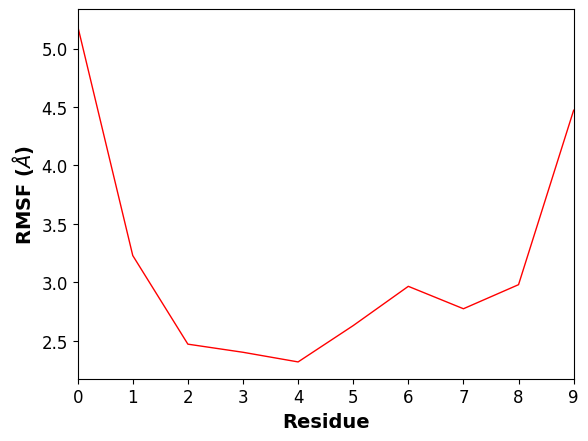

In [53]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

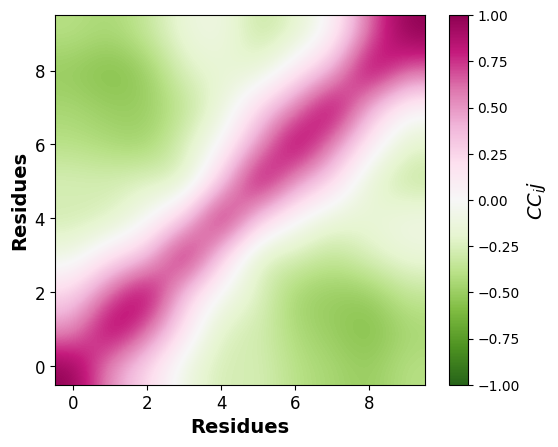

In [54]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:**
Output_name = 'cross_correlation' #@param {type:"string"}

from pytraj import matrix
traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))